# _Expansiones Basales y No-linealidades_

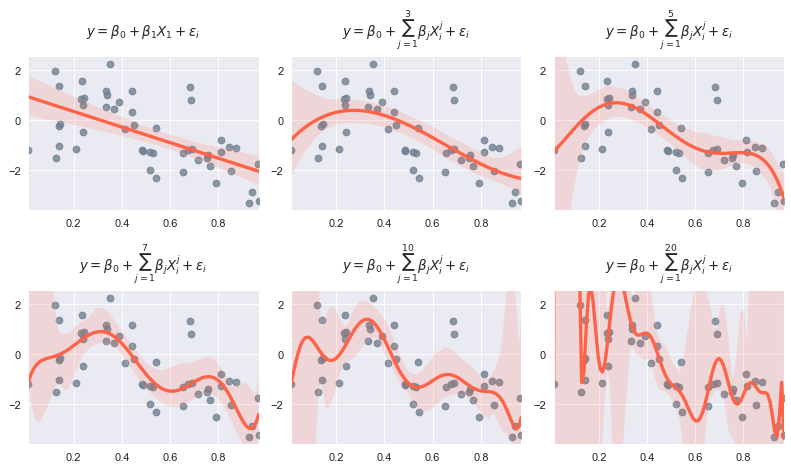

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import lec2_graphs as afx
import warnings
warnings.filterwarnings(action='ignore')
plt.rcParams["figure.figsize"] = (10, 6) # Tamaño gráficos
plt.rcParams["figure.dpi"] = 80 # resolución gráficos
sn.set_style('darkgrid')
afx.polynomial_degrees()

## Implementando un Modelo Aditivo Generalizado con pygam


In [3]:
from sklearn.preprocessing import StandardScaler
df = pd.read_csv('kc_house_data.csv')
# Vamos a eliminar ciertas columnas que son irrelevantes para nuestro analisis
df.drop(['zipcode', 'id', 'date'], axis = 1, inplace = True)
# Vamos a utilizar un subconjunto de las columnas para hacer el ejemplo
# mas expedito
sub = df[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot']]

In [6]:
from sklearn.model_selection import train_test_split
# X será nuestro conjunto de atributos e y será nuestra variable objetivo
X_train_pre, X_test_pre, y_train, y_test = train_test_split(sub, df['price'], test_size =.3, random_state = 63)
# Ajustamos el estandarizador sobre el conjunto de entrenamiento (para que aprenda la media y desv. est.)
scaler = StandardScaler().fit(X_train_pre)
# Con el estandarizador ajustado sobre entrenamiento, transformamos el conjunto de entrenamiento con esta estandarizacion
X_train = pd.DataFrame(scaler.transform(X_train_pre), columns = X_train_pre.columns)
# Transformamos el conjunto de pruebas con el estandarizador ajustado sobre entrenamiento
X_test = pd.DataFrame(scaler.transform(X_test_pre), columns = X_test_pre.columns)

In [31]:
from pygam import LinearGAM, s
# definimos el rango de hiperparametros a evaluar
lams = np.logspace(-3, 3, 3)
# Necesitamos generar copias de esta lista de valores a evaluar para cada funcion f(X), que en nuestro caso serán splines
lams = [lams]* len(X_train.columns)
# Definimos el modelo indicandole qué tipo de función debe tratar de ajustar a cada atributo/variable independiente en la matriz que le entregaremos: s(0) significa que se debe ajustar un término de tipo spline a la primera columna entregada
gam = LinearGAM(s(0) + s(1) + s(2) + s(3), fit_intercept=True).fit(X_train, y_train)
# Realizamos el proceso de búsqueda por gridsearch invocando al método del mismo nombre
gam.gridsearch(X_train, y_train, lam = lams)
# Con el método summary obtenemos una tabla con los resultados del ajuste del modelo para la mejor combinación de hiper parámetros
gam.summary()

100% (81 of 81) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     50.5084
Link Function:                     IdentityLink Log Likelihood:                               -388710.4607
Number of Samples:                        15129 AIC:                                           777523.9383
                                                AICc:                                           777524.297
                                                GCV:                                      57794407073.9769
                                                Scale:                                    57447204678.7826
                                                Pseudo R-Squared:                                   0.5944
Feature Function                  Lam

In [35]:
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error

def report_gam_metrics(model, X_test, y_test):
 print('Test R^2: {0}'.format(r2_score(y_test, model.predict(X_test)).round(3)))
 print('Test RMSE: {0}'.format(mean_squared_error(y_test, model.predict(X_test)).round(3)))
 print('Test Median Absolute Error: {0}'.format(median_absolute_error(y_test, model.predict(X_test)).round(3)))

report_gam_metrics(gam, X_test, y_test)

Test R^2: 0.504
Test RMSE: 59381987543.509
Test Median Absolute Error: 120633.493


## Dependencia Parcial

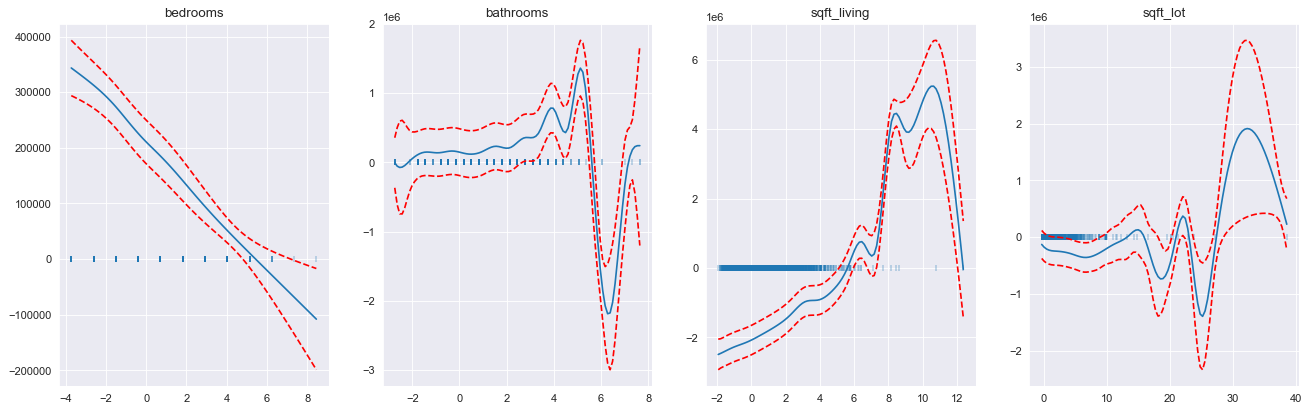

In [37]:
fig, axs = plt.subplots(1,4, figsize = (20,6))
titles = X_train.columns
for i, ax in enumerate(axs.flatten()):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.scatter(X_train[titles[i]], [0] * len(X_train[titles[i]]), marker = '|', alpha = .3)
    ax.set_title(titles[i])